# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# checking sklearn version
import sklearn
sklearn.__version__

'0.19.1'

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", delimiter=';')

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", delimiter=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info['information_level'].unique()

array(['person', 'household', 'building', 'microcell_rr4', 'microcell_rr3',
       'postcode', 'region_rr1', 'macrocell_plz8', 'community'], dtype=object)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [8]:
# missing values in original data 
print(sum(azdias.isnull().sum()))
azdias.isnull().sum().describe()

4896838


count        85.000000
mean      57609.858824
std       78323.462873
min           0.000000
25%           0.000000
50%       18348.000000
75%       98979.000000
max      584612.000000
dtype: float64

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
def missing_data_correction(attribute, missing_val):
    for val in missing_val.strip('][').split(','):
        try:
            azdias[attribute].replace(int(val), np.nan, inplace=True)
        except Exception as e:
            # handling string column type
            azdias[attribute].replace(val, np.nan, inplace=True)
            continue
            

In [10]:
for data in feat_info.iterrows():
    missing_data_correction(data[1]['attribute'], data[1]['missing_or_unknown'])
azdias

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.
null_arr = np.array(azdias.isnull().sum().tolist())
print(null_arr)
azdias.isnull().sum()

[685843   2881      0   4854      0      0      0      0      0      0
      0 392318   4854      0 111196  97632  94572  77792  77792   4854
   4854 108315 108164   4854      0      0      0      0      0      0
      0      0      0      0      0      0      0      0 111196  73499
 889061 111196      0 310267  73499  73499  18348 584612 147988  73499
  99611  97008  93148  73969  93148  93148  93148  99352  99352  99352
 133324 133324 133324 133324 476524 133324  93740  93740  93740  93155
 158064 133324   4854 158064 105800 116515 116515 116515 116515 116515
 116515 116515  97375  97274  97375]


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [12]:
# Investigate patterns in the amount of missing data in each column.
azdias.isnull().sum().describe()

count        85.000000
mean      98516.811765
std      146604.203317
min           0.000000
25%           0.000000
50%       93148.000000
75%      116515.000000
max      889061.000000
dtype: float64

In [13]:
# no of features with same null values
from collections import Counter
print(Counter(null_arr))

Counter({0: 24, 116515: 7, 4854: 6, 133324: 6, 73499: 4, 93148: 4, 111196: 3, 99352: 3, 93740: 3, 77792: 2, 158064: 2, 97375: 2, 685843: 1, 2881: 1, 392318: 1, 97632: 1, 94572: 1, 108315: 1, 108164: 1, 889061: 1, 310267: 1, 18348: 1, 584612: 1, 147988: 1, 99611: 1, 97008: 1, 73969: 1, 476524: 1, 93155: 1, 105800: 1, 97274: 1})


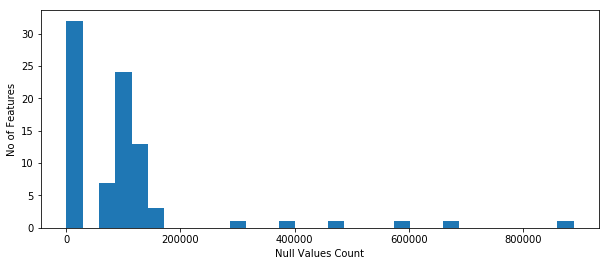

In [14]:
plt.figure(figsize=(10,4))
plt.hist(null_arr, bins=len(Counter(null_arr)))
plt.xlabel('Null Values Count')
plt.ylabel('No of Features')
plt.show()

In [15]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_columns = []
for col in azdias:
    if sum(azdias[col].isnull())>200000:
        outlier_columns.append(col)
outlier_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [16]:
# removing outlier columns from the dataset
azdias_cleaned = azdias.drop(labels=outlier_columns, axis=1)
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
# removed features description
feat_info[feat_info['attribute'].isin(outlier_columns)]

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
11,GEBURTSJAHR,person,numeric,[0]
40,TITEL_KZ,person,categorical,"[-1,0]"
43,ALTER_HH,household,interval,[0]
47,KK_KUNDENTYP,household,categorical,[-1]
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"


#### Discussion 1.1.2: Assess Missing Data in Each Column

Although different columns vary with missing data but there are columns with same no of missing values from which we could make some asumptions about data distribution and information about different columns. 

Missing values distribution for different columns are as follow:
( (0: 24), (116515: 7), (4854: 6), (133324: 6), (73499: 4), (93148: 4), (111196: 3), (99352: 3), (93740: 3), (77792: 2), (158064: 2), (97375: 2), (685843: 1), (2881: 1), (392318: 1), (97632: 1), (94572: 1), (108315: 1), (108164: 1), (889061: 1), (310267: 1), (18348: 1), (584612: 1), (147988: 1), (99611: 1), (97008: 1), (73969: 1), (476524: 1), (93155: 1), (105800: 1), (97274: 1) )

There are 7 features with most common missing values (116515) and they all belong to PLZ8 macro-cell features. These features contains information regarding the building types and family houses of the region a person lives in. Maybe all the people with missing data lives in the same region for which there is not much data. 

The features that have 4845 missing values mostly come from different feature categories: CJT_GESAMTTYP, GFK_URLAUBERTYP, RETOURTYP_BK_S, ONLINE_AFFINITAET, apart from LP_STATUS_FEIN and LP_STATUS_GROB which are the same feature on a fine and rough scale. Since they are mostly different features describing different things maybe certain people didn't feel comfortable disclosing this information.

Also, there are 6 features with data values missing above 200000 in each column, which is approximately 25% of data in each column, we are considering these features as outliers and won't take them into account for analysis since they don't contain much information for analysis. These features are as follow: ['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']
 Most of these features contains personal information of customers and that might be the reason for so many missing values, since people doesn't always feel comfortable in relieving their personal information.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [18]:
# How much data is missing in each row of the dataset?
null_in_rows = np.array(azdias.isnull().sum(axis=1))
print(null_in_rows)
azdias.isnull().sum(axis=1).describe()

[49  4  4 ...,  9  5  6]


count    891221.000000
mean          9.396018
std          13.971829
min           0.000000
25%           3.000000
50%           4.000000
75%           6.000000
max          54.000000
dtype: float64

In [19]:
Counter(azdias.isnull().sum(axis=1))

Counter({49: 27357,
         4: 133473,
         9: 15432,
         3: 189850,
         2: 135292,
         5: 110108,
         53: 45579,
         10: 11524,
         11: 14993,
         16: 2699,
         6: 71615,
         24: 364,
         40: 2724,
         7: 17502,
         46: 124,
         8: 16808,
         12: 11943,
         51: 483,
         1: 30377,
         33: 19,
         21: 1272,
         23: 541,
         14: 7270,
         22: 1255,
         38: 3975,
         20: 1799,
         39: 2316,
         13: 11865,
         18: 3381,
         37: 4445,
         19: 2754,
         43: 160,
         17: 2416,
         36: 2534,
         41: 2065,
         42: 262,
         31: 25,
         30: 52,
         35: 443,
         28: 114,
         15: 2451,
         50: 105,
         45: 75,
         26: 216,
         29: 85,
         47: 323,
         25: 257,
         48: 51,
         0: 143,
         27: 130,
         44: 131,
         32: 29,
         34: 14,
         54: 1}

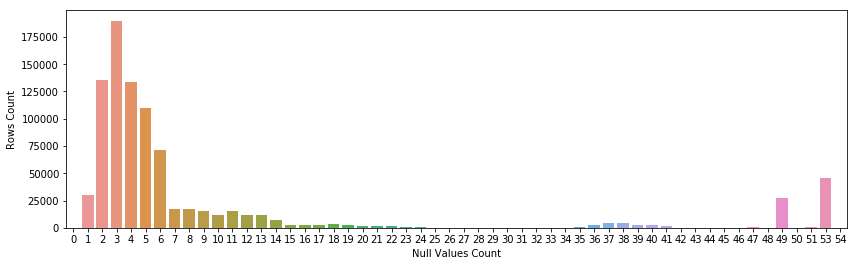

In [20]:
plt.figure(figsize=(14,4))
ax = sns.countplot(azdias.isnull().sum(axis=1))
ax.set_xlabel('Null Values Count')
ax.set_ylabel('Rows Count')
plt.show()

In [21]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_cleaned['nulls'] = azdias_cleaned.isnull().sum(axis=1)
azdias_cleaned.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nulls
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [22]:
azdias_low_18 = azdias_cleaned[azdias_cleaned['nulls']<18]
azdias_low_18.drop(labels='nulls', axis=1, inplace=True)
print(azdias_low_18.shape)

(795469, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
azdias_high_18 = azdias_cleaned[azdias_cleaned['nulls']>=18]
azdias_high_18.drop(labels='nulls', axis=1, inplace=True)
print(azdias_high_18.shape)

(95752, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [24]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def distribution_graph(col):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4), sharey=True)
    
    ax1.set_title('Null_Low_18 Data')
    counts = azdias_low_18[col].value_counts()
    ax1.bar(counts.index, counts.values)
    ax1.set_xlabel(col)
#     azdias_lower_18[col].value_counts().plot.bar()
    
    ax2.set_title('Null_High_18 Data')
    counts = azdias_high_18[col].value_counts()
    ax2.bar(counts.index, counts.values)
    ax2.set_xlabel(col)
#     azdias_higher_18[col].value_counts().plot.bar()
    plt.tight_layout()
    plt.show()

In [25]:
distribution_cols = []
counter=0
for col in azdias_cleaned:
    low_18_nulls = azdias_low_18[col].isnull().sum()
    high_18_nulls = azdias_high_18[col].isnull().sum()
    if (low_18_nulls+high_18_nulls == 0):
        counter += 1
        distribution_cols.append(col)
        if counter == 10:
            break
distribution_cols

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ']

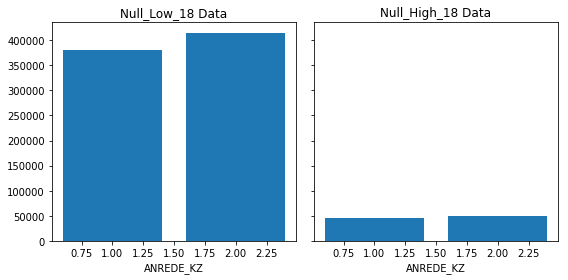

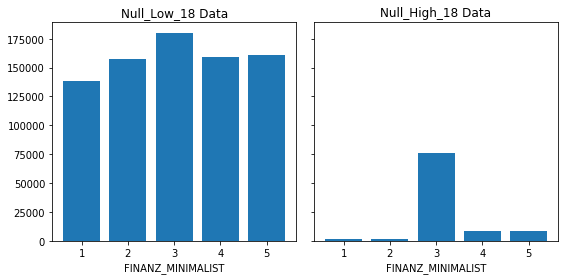

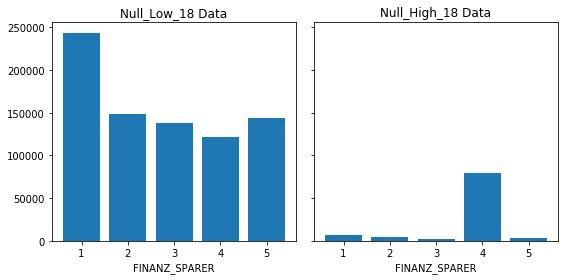

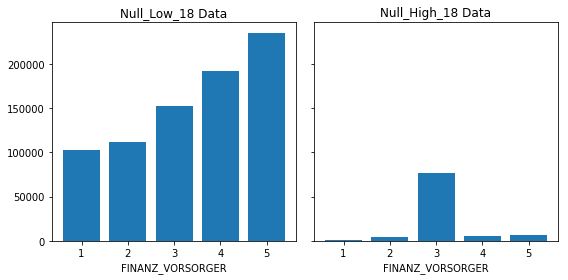

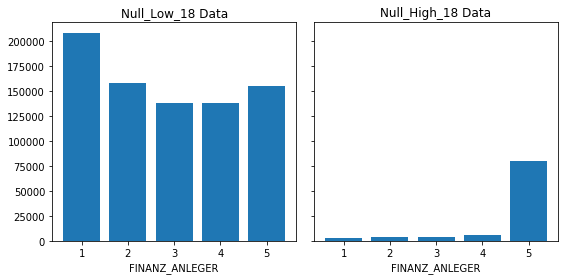

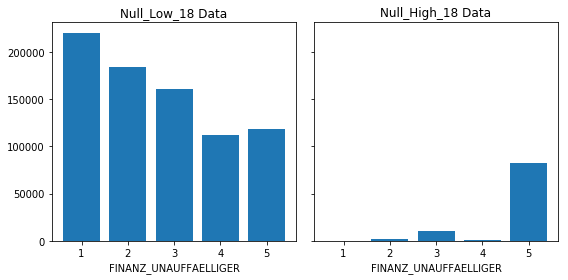

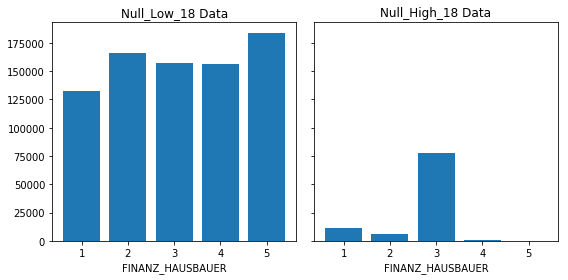

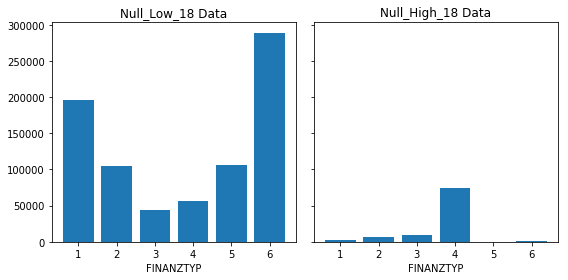

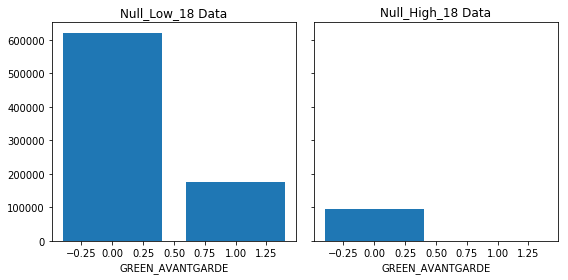

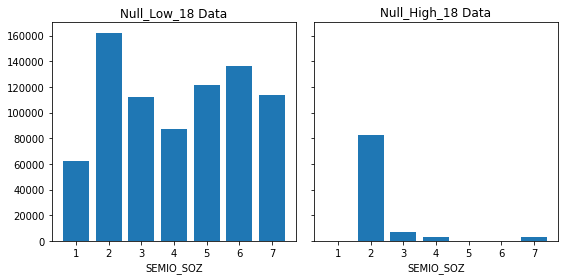

In [26]:
for col in distribution_cols:
    distribution_graph(col)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I have taken into consideration 10 features for observing distribution of data with null values per row lower than 18 (azdias_low_18) and null values per row higher than 18 (azdias_high_18). I have chosen threshold of 18 for missing values count per row with the help of countplot for dataset azdiaz, as shown in the graph above. 

After comparing two subsets, namely, azdias_lower_18 and azdias_high_18, it is clear that the distribution of data doesn't looks similar. From this we can conclude that its not the best suggestion to discard the rows with high missing values, since it may distort the data and it seems to be qualitatively different. so we will revist high missing value data set later in our analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?
feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# categorical attributes list
categorical_feat = feat_info[feat_info['type']=='categorical']['attribute'].tolist()
categorical_feat

['AGER_TYP',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'TITEL_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'KK_KUNDENTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [29]:
# removing outlier features from categorical features list
categorical_feat = list(set(categorical_feat) - set(outlier_columns))
categorical_feat

['CJT_GESAMTTYP',
 'LP_STATUS_GROB',
 'CAMEO_DEUG_2015',
 'LP_STATUS_FEIN',
 'GEBAEUDETYP',
 'VERS_TYP',
 'GREEN_AVANTGARDE',
 'ZABEOTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'OST_WEST_KZ',
 'GFK_URLAUBERTYP',
 'SHOPPER_TYP',
 'LP_FAMILIE_FEIN',
 'SOHO_KZ',
 'NATIONALITAET_KZ',
 'CAMEO_DEU_2015',
 'ANREDE_KZ']

In [30]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
for col in categorical_feat:
    print(azdias_low_18[col].isnull().sum())
    print(azdias_low_18[col].describe())

4515
count    790954.000000
mean          3.502068
std           1.537382
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: CJT_GESAMTTYP, dtype: float64
4515
count    790954.000000
mean          2.458376
std           1.511701
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: LP_STATUS_GROB, dtype: float64
4707
count     790762
unique         9
top            8
freq      134356
Name: CAMEO_DEUG_2015, dtype: object
4515
count    790954.000000
mean          4.786438
std           3.520469
min           1.000000
25%           1.000000
50%           4.000000
75%           9.000000
max          10.000000
Name: LP_STATUS_FEIN, dtype: float64
0
count    795469.000000
mean          2.802312
std           2.658943
min           1.000000
25%           1.000000
50%           1.000000
75%           3.000000
max           8.000000
Name: GEBAEUDETYP, dtype: f

In [31]:
azdias_low_18['OST_WEST_KZ'].value_counts()

W    627333
O    168136
Name: OST_WEST_KZ, dtype: int64

In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_low_18['WEST_KZ'] = azdias_low_18['OST_WEST_KZ'].replace({'W':1, 'O':0})
azdias_low_18['WEST_KZ'].value_counts()
azdias_low_18.drop(labels='OST_WEST_KZ', axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [33]:
#  defining imputer function based on max frequency
def imputer_frequency(df, col):
    most_freq = df[col].value_counts().idxmax()
    return df[col].fillna(most_freq)

In [34]:
categorical_feat

['CJT_GESAMTTYP',
 'LP_STATUS_GROB',
 'CAMEO_DEUG_2015',
 'LP_STATUS_FEIN',
 'GEBAEUDETYP',
 'VERS_TYP',
 'GREEN_AVANTGARDE',
 'ZABEOTYP',
 'FINANZTYP',
 'LP_FAMILIE_GROB',
 'OST_WEST_KZ',
 'GFK_URLAUBERTYP',
 'SHOPPER_TYP',
 'LP_FAMILIE_FEIN',
 'SOHO_KZ',
 'NATIONALITAET_KZ',
 'CAMEO_DEU_2015',
 'ANREDE_KZ']

In [35]:
#  desired categorical features
categorical_feat = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
for col in categorical_feat:
    # imputing missing value with most frequent value in feature
    imputed_data = imputer_frequency(azdias_low_18, col)
    # one hot encoding
    azdias_low_18_encoded = pd.get_dummies(imputed_data, prefix=col)
    # dropping column that is hot encoded
    azdias_low_18 = azdias_low_18.drop(col, axis=1)
    
    #insert new encoded columns into the dataset
    for col in azdias_low_18_encoded.columns: 
        azdias_low_18[col] = azdias_low_18_encoded[col] 
    
azdias_low_18.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
count,792713.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,759299.00000,...,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000,795469.000000
mean,2.795546,1.521375,3.057963,2.715340,3.433617,2.840504,2.654503,3.118631,0.219752,2.19979,...,0.005812,0.065892,0.041994,0.038936,0.022080,0.025814,0.034768,0.031408,0.035934,0.007993
std,1.018517,0.499543,1.377607,1.485188,1.376866,1.472640,1.398538,1.406895,0.414079,0.75512,...,0.076012,0.248093,0.200576,0.193441,0.146944,0.158579,0.183192,0.174418,0.186125,0.089044
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000,0.000000,2.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.000000,2.000000,3.000000,3.000000,4.000000,3.000000,2.000000,3.000000,0.000000,2.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,0.000000,3.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000,3.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
azdias_low_18.shape

(795469, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features

* Binary variable that takes on non-numeric values is OST_WEST_KZ. This one is re encoded with value 0 and 1.
* SOHO_KZ and GREEN_AVANTGARDE is a regular binary variable
* ANREDE_KZ is binary, but takes values [1,2]
* All the multi-level categorical variables are encoded via One Hot encoding
* Variables that are not considered or dropped earlier are -  ['AGER_TYP', 'GEBURTSJAHR',  'TITEL_KZ',  'ALTER_HH',  'KK_KUNDENTYP',  'KBA05_BAUMAX']. These variables are outliers and dont have much information as compared to other vaiables. So it wont be much useful for analysis.

Engineering steps performed are as follow:
* convert OST_WEST_KZ to binary variable: WEST_KZ
   * W maps to 1 (signifies True/1 for "west")
   * O maps to 0
* Imputed Categorical variables with most common or frequent value in each feature, since it makes more sense to use mode instaed of mean for data imputation of categorical variables
* Lastly, one hot ecncoded all the categorical vaiables using pandas get_dummies function

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
azdias['PRAEGENDE_JUGENDJAHRE']

0          NaN
1         14.0
2         15.0
3          8.0
4          8.0
5          3.0
6         10.0
7          8.0
8         11.0
9         15.0
10         3.0
11         NaN
12         8.0
13        15.0
14         NaN
15         5.0
16        14.0
17         NaN
18        10.0
19         9.0
20        11.0
21        10.0
22        14.0
23         9.0
24         NaN
25        14.0
26         8.0
27        11.0
28        10.0
29         6.0
          ... 
891191     3.0
891192    14.0
891193     5.0
891194    11.0
891195     8.0
891196    14.0
891197    11.0
891198    15.0
891199    10.0
891200    14.0
891201    10.0
891202    10.0
891203     NaN
891204    10.0
891205     3.0
891206    14.0
891207     2.0
891208     8.0
891209    14.0
891210     8.0
891211     8.0
891212     3.0
891213    11.0
891214    14.0
891215    10.0
891216    14.0
891217    10.0
891218    14.0
891219    14.0
891220     3.0
Name: PRAEGENDE_JUGENDJAHRE, Length: 891221, dtype: float64

In [38]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
print(azdias['PRAEGENDE_JUGENDJAHRE'].value_counts())
decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
avantgarde_mainstream_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}

azdias_low_18['AVANTGARDE_MAINSTREAM'] = azdias_low_18['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mainstream_mapping)
azdias_low_18['YOUTH_DECADE'] = azdias_low_18['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

# impute null values
azdias_low_18['AVANTGARDE_MAINSTREAM'] = imputer_frequency(azdias_low_18, 'AVANTGARDE_MAINSTREAM')
azdias_low_18['YOUTH_DECADE'] = imputer_frequency(azdias_low_18, 'YOUTH_DECADE')

# dropping the original PRAEGENDE_JUGENDJAHRE feature to avoid data distortion and bias 
azdias_low_18.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

14.0    188697
8.0     145988
5.0      86416
10.0     85808
3.0      55195
15.0     42547
11.0     35752
9.0      33570
6.0      25652
12.0     24446
1.0      21282
4.0      20451
2.0       7479
13.0      5764
7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64


In [39]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_low_18['CAMEO_INTL_2015'].value_counts()

51    133640
41     92256
24     91010
14     62802
43     56618
54     45351
25     39573
22     33090
23     26565
13     26293
45     26108
55     23922
52     20534
31     18922
34     18498
15     16960
44     14807
12     13213
35     10342
32     10340
33      9918
Name: CAMEO_INTL_2015, dtype: int64

In [40]:
azdias_low_18['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'], dtype=object)

In [41]:
# Engineering CAMEO_INTL_2015 feature
azdias_low_18['CAMEO_INTL_2015_WEALTH'] = azdias_low_18['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if len(str(x))==2 else np.nan)
# imputing nan 
azdias_low_18['CAMEO_INTL_2015_WEALTH'] = imputer_frequency(azdias_low_18, 'CAMEO_INTL_2015_WEALTH')
print(azdias_low_18['CAMEO_INTL_2015_WEALTH'].unique())

azdias_low_18['CAMEO_INTL_2015_LIFE'] = azdias_low_18['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if len(str(x))==2 else np.nan)
# imputing nan 
azdias_low_18['CAMEO_INTL_2015_LIFE'] = imputer_frequency(azdias_low_18, 'CAMEO_INTL_2015_LIFE')
print(azdias_low_18['CAMEO_INTL_2015_LIFE'].unique())

# dropping original feature
azdias_low_18.drop(labels='CAMEO_INTL_2015', axis=1, inplace=True)

[ 5.  2.  1.  4.  3.]
[ 1.  4.  2.  3.  5.]


In [42]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [43]:
# mixed type features list
mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
# removing PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 from the list
mixed_features = list(set(mixed_features)- {'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'})
mixed_features

['LP_LEBENSPHASE_GROB',
 'WOHNLAGE',
 'LP_LEBENSPHASE_FEIN',
 'PLZ8_BAUMAX',
 'KBA05_BAUMAX']

In [44]:
#  exploring remaining mixed type features
for feature in mixed_features:
    try:
        print(azdias_low_18[feature].describe())
        print("Null Counts for feature ", feature, ':  ',str(azdias_low_18[feature].isnull().sum()))
        print("-----------------------------------------")
    except Exception as e: #since one feature is part of removed outlier featue
        print(e)

count    749084.000000
mean          4.946623
std           3.743971
min           1.000000
25%           2.000000
50%           3.000000
75%           8.000000
max          12.000000
Name: LP_LEBENSPHASE_GROB, dtype: float64
Null Counts for feature  LP_LEBENSPHASE_GROB :   46385
-----------------------------------------
count    795469.000000
mean          4.056872
std           1.944681
min           0.000000
25%           3.000000
50%           3.000000
75%           5.000000
max           8.000000
Name: WOHNLAGE, dtype: float64
Null Counts for feature  WOHNLAGE :   0
-----------------------------------------
count    746280.000000
mean         16.308856
std          12.226714
min           1.000000
25%           6.000000
50%          13.000000
75%          28.000000
max          40.000000
Name: LP_LEBENSPHASE_FEIN, dtype: float64
Null Counts for feature  LP_LEBENSPHASE_FEIN :   49189
-----------------------------------------
count    774572.000000
mean          1.944047
std        

In [45]:
# engineering WOHNLAGE feature 
print(azdias_low_18['WOHNLAGE'].value_counts())
# imputing value for 'No Score Category ie 0' with max frequent value
max = azdias_low_18['WOHNLAGE'].value_counts().idxmax()
azdias_low_18['WOHNLAGE'].replace(0.0, max, inplace=True)
print(azdias_low_18['WOHNLAGE'].value_counts())

3.0    249310
7.0    169088
4.0    135732
2.0    100207
5.0     74158
1.0     43830
8.0     17201
0.0      5943
Name: WOHNLAGE, dtype: int64
3.0    255253
7.0    169088
4.0    135732
2.0    100207
5.0     74158
1.0     43830
8.0     17201
Name: WOHNLAGE, dtype: int64


In [46]:
# dividing WOHNLAGE feature into RURAL Flag
rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
azdias_low_18['RURAL'] = azdias_low_18['WOHNLAGE'].map(rural_map)
print(azdias_low_18['RURAL'].value_counts())

0    609180
1    186289
Name: RURAL, dtype: int64


In [47]:
# dropping remaining mixed type feature as remaining features information is captured by other features 
for feature in mixed_features:
    try:
        azdias_low_18.drop(labels=feature, axis=1, inplace=True)
    except Exception as e:
        continue
azdias_low_18

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE_MAINSTREAM,YOUTH_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,RURAL
1,1.0,2,1,5,2,5,4,5,0,3.0,...,0,0,0,0,0,0.0,90.0,5.0,1.0,0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0,0,0,0,0,1.0,90.0,2.0,4.0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0,0,0,0,0,0.0,70.0,1.0,2.0,1
4,3.0,1,4,3,4,1,3,2,0,3.0,...,0,0,0,0,0,0.0,70.0,4.0,3.0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,0,0,0,0,0,0.0,50.0,5.0,4.0,1
6,2.0,2,1,5,1,5,4,3,0,2.0,...,0,0,0,0,0,0.0,80.0,2.0,2.0,0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,0,0,0,0,0,0.0,70.0,1.0,4.0,0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,0,0,0,0,0,1.0,80.0,1.0,3.0,0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,0,0,0,0,0,1.0,90.0,1.0,5.0,1
10,3.0,2,2,2,5,3,1,5,0,2.0,...,0,0,0,1,0,0.0,50.0,5.0,1.0,0


#### Discussion 1.2.2: Engineer Mixed-Type Features

##### Engineering PRAEGENDE_JUGENDJAHRE feature
PRAEGENDE_JUGENDJAHRE feature is divided into two sub features, namely, AVANTGARDE_MAINSTREAM and YOUTH_DECADE. Mapping has been created for both the variables from the original data set. 

For AVANTGARDE_MAINSTREAM, binary values of 0 and 1 is used for mapping where 0 indicates Mainstream movement and 1 indicates Avantgarde movement.

For YOUTH_DECADE feature, decade of person is used for mapping. For ex: 40s become 40

Null values in both the sub features are handled by imputing it with the most frequent value. Finally dropped the original PRAEGENDE_JUGENDJAHRE column from dataset.

##### Engineering CAMEO_INTL_2015 feature
Feature CAMEO_INTL_2015 contains information about persons lifestage and Wealth. So this feature is sub divided into CAMEO_INTL_2015_WEALTH and CAMEO_INTL_2015_LIFE. 

CAMEO_INTL_2015_WEALTH feature is mapped into values : 1,2,3,4,5. Each value is retrieved from the first digit of the orginial variable which shows the wealth status.

CAMEO_INTL_2015_LIFE feature is mapped into values : 1,2,3,4,5. Each value is retrieved from the second digit of the orginial variable which shows the wealth status.

Null values in both the sub features are handled by imputing it with the most frequent value. Finally dropped the original CAMEO_INTL_2015 column from dataset.

##### Engineering other mixed-type features
* Feature WOHNLAGE is converted into binary variable, where 0 indicates non rural neighborhood and 1 indicates rural neighborhood. Unknown values are imputed with most frequent value

* Feature KBA05_BAUMAX is an outlier, so it was dropped earlier from dataset

* Feature LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB contains information about life stage and wealth, this information is covered under feature CAMEO_INTL_2015. So dropped feature LP_LEBENSPHASE_FEIN and LP_LEBENSPHASE_GROB from dataset

* Feature PLZ8_BAUMAX is encapsulated by the information in other PLZ8 variables, so it is dropped

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
outlier_columns

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [49]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for data in feat_info.iterrows():
        for val in data[1]['missing_or_unknown'].strip('][').split(','):
            try:
                df[data[1]['attribute']].replace(int(val), np.nan, inplace=True)
            except Exception as e:
                # handling string column type
                df[data[1]['attribute']].replace(val, np.nan, inplace=True)
                continue
    
    # remove selected columns and rows, ...
    outlier_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    for col in df:
        if sum(df[col].isnull())>200000:
            outlier_columns.append(col)
    df_cleaned = df.drop(labels=outlier_columns, axis=1)
    
    
    df_cleaned['nulls'] = df_cleaned.isnull().sum(axis=1)
    df_low_18 = df_cleaned[df_cleaned['nulls']<18]
    df_low_18.drop(labels='nulls', axis=1, inplace=True)
    # select, re-encode, and engineer column values.
    categorical_feat = feat_info[feat_info['type']=='categorical']['attribute'].unique().tolist()
    categorical_feat = list(set(categorical_feat) - set(outlier_columns))
    
    df_low_18['WEST_KZ'] = df_low_18['OST_WEST_KZ'].replace({'W':1, 'O':0})
    df_low_18.drop(labels='OST_WEST_KZ', axis=1, inplace=True)
    
    #  desired categorical features
    categorical_feat = ['CJT_GESAMTTYP', 'FINANZTYP','GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 
                'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 
                'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
    for col in categorical_feat:
        imputed_data = imputer_frequency(df_low_18, col)
        # one hot encoding
        df_low_18_encoded = pd.get_dummies(imputed_data, prefix=col)
        df_low_18 = df_low_18.drop(col, axis=1)
        #insert new encoded columns into the dataset
        for col in df_low_18_encoded.columns: 
            df_low_18[col] = df_low_18_encoded[col]
            
            
    decade_mapping = {1:40, 2:40,3:50,4:50,5:60,6:60,7:60,8:70,9:70,10:80,11:80,12:80,13:80,14:90,15:90}
    avantgarde_mainstream_mapping ={1:0,2:1,3:0,4:1,5:0,6:1,7:1,8:0,9:1,10:0,11:1,12:0,13:1,14:0,15:1}
    
    df_low_18['AVANTGARDE_MAINSTREAM'] = df_low_18['PRAEGENDE_JUGENDJAHRE'].map(avantgarde_mainstream_mapping)
    df_low_18['YOUTH_DECADE'] = df_low_18['PRAEGENDE_JUGENDJAHRE'].map(decade_mapping)

    # impute null values
    df_low_18['AVANTGARDE_MAINSTREAM'] = imputer_frequency(df_low_18, 'AVANTGARDE_MAINSTREAM')
    df_low_18['YOUTH_DECADE'] = imputer_frequency(df_low_18, 'YOUTH_DECADE')

    # dropping the original PRAEGENDE_JUGENDJAHRE feature to avoid data distortion and bias 
    df_low_18.drop(labels='PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    
    # Engineering CAMEO_INTL_2015 feature
    df_low_18['CAMEO_INTL_2015_WEALTH'] = df_low_18['CAMEO_INTL_2015'].apply(lambda x: int(x[0]) if len(str(x))==2 else np.nan)
    # imputing nan 
    df_low_18['CAMEO_INTL_2015_WEALTH'] = imputer_frequency(df_low_18, 'CAMEO_INTL_2015_WEALTH')
    df_low_18['CAMEO_INTL_2015_LIFE'] = df_low_18['CAMEO_INTL_2015'].apply(lambda x: int(x[1]) if len(str(x))==2 else np.nan)
    # imputing nan 
    df_low_18['CAMEO_INTL_2015_LIFE'] = imputer_frequency(df_low_18, 'CAMEO_INTL_2015_LIFE')
    # dropping original feature
    df_low_18.drop(labels='CAMEO_INTL_2015', axis=1, inplace=True)
    
    # mixed type features list
    mixed_features = feat_info[feat_info['type'] == 'mixed']['attribute'].tolist()
    # removing PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 from the list
    mixed_features = list(set(mixed_features)- {'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'})
    
    max_val = df_low_18['WOHNLAGE'].value_counts().idxmax()
    df_low_18['WOHNLAGE'].replace(0.0, max_val, inplace=True)
    
    # dividing WOHNLAGE feature into RURAL Flag
    rural_map={1:0,2:0,3:0,4:0,5:0,7:1,8:1}
    df_low_18['RURAL'] = df_low_18['WOHNLAGE'].map(rural_map)
    
    # dropping remaining mixed type feature as remaining features information is captured by other features 
    for feature in mixed_features:
        try:
            df_low_18.drop(labels=feature, axis=1, inplace=True)
        except Exception as e:
            continue
            
    # Return the cleaned dataframe.
    return df_low_18
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [50]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
null_data = azdias_low_18.isnull().sum()
print(np.array(null_data))
null_data

[ 2756     0     0     0     0     0     0     0     0 36170  4515     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0 36170     0     0     0 58497     0  6236  3640    57     0
 37640 37640 37640 37640 37640   577   577   577     5 62802 37640  4515
 62802 10899 20897 20897 20897 20897 20897 20897  4190  4091  4190     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0   

ALTERSKATEGORIE_GROB       2756
ANREDE_KZ                     0
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
GREEN_AVANTGARDE              0
HEALTH_TYP                36170
RETOURTYP_BK_S             4515
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KULT                    0
SEMIO_RAT                     0
SEMIO_KRIT                    0
SEMIO_DOM                     0
SEMIO_KAEM                    0
SEMIO_PFLICHT                 0
SEMIO_TRADV                   0
SOHO_KZ                       0
VERS_TYP                  36170
ANZ_PERSONEN                  0
ANZ_TITEL                     0
HH_EINKOMMEN_SCORE            0
                          ...  
CAMEO_DE

In [51]:
#  getting all columns with missing values
null_cols=dict()
for feature in azdias_low_18:
    if azdias_low_18[feature].isnull().sum()>0:
        null_cols[feature] = azdias_low_18[feature].isnull().sum()
null_cols

{'ALTERSKATEGORIE_GROB': 2756,
 'HEALTH_TYP': 36170,
 'RETOURTYP_BK_S': 4515,
 'VERS_TYP': 36170,
 'W_KEIT_KIND_HH': 58497,
 'ANZ_HAUSHALTE_AKTIV': 6236,
 'ANZ_HH_TITEL': 3640,
 'KONSUMNAEHE': 57,
 'KBA05_ANTG1': 37640,
 'KBA05_ANTG2': 37640,
 'KBA05_ANTG3': 37640,
 'KBA05_ANTG4': 37640,
 'KBA05_GBZ': 37640,
 'BALLRAUM': 577,
 'EWDICHTE': 577,
 'INNENSTADT': 577,
 'GEBAEUDETYP_RASTER': 5,
 'KKK': 62802,
 'MOBI_REGIO': 37640,
 'ONLINE_AFFINITAET': 4515,
 'REGIOTYP': 62802,
 'KBA13_ANZAHL_PKW': 10899,
 'PLZ8_ANTG1': 20897,
 'PLZ8_ANTG2': 20897,
 'PLZ8_ANTG3': 20897,
 'PLZ8_ANTG4': 20897,
 'PLZ8_HHZ': 20897,
 'PLZ8_GBZ': 20897,
 'ARBEIT': 4190,
 'ORTSGR_KLS9': 4091,
 'RELAT_AB': 4190}

In [52]:
azdias_low_18.isnull().sum(axis=0).describe()


count      193.000000
mean      3391.129534
std      10968.713298
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      62802.000000
dtype: float64

In [53]:
# most frequent occuring highest missing value is 37,640 which is still only about 4.8% of values
from sklearn.preprocessing import Imputer

imputer = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
azdias_low_18 = pd.DataFrame(imputer.fit_transform(azdias_low_18),
                              index=azdias_low_18.index, columns=azdias_low_18.columns)

#end result is new imputed DF

In [54]:
# # imputing missing values 
azdias_low_18.isnull().sum().describe()

count    193.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [55]:
azdias_low_18.isnull().sum(axis=1).describe()

count    795469.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

In [56]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_low_18),
                              index=azdias_low_18.index, columns=azdias_low_18.columns)
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE_MAINSTREAM,YOUTH_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,RURAL
count,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,...,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05,7.954690e+05
mean,-1.664280e-16,1.952238e-16,5.049025e-17,8.949123e-17,1.971375e-17,1.200980e-16,1.041336e-16,5.724759e-17,4.984489e-17,3.048396e-16,...,5.340862e-17,-4.628757e-17,1.163219e-17,-2.608253e-17,-4.780607e-17,4.984489e-17,2.828325e-17,3.416633e-17,-7.497836e-17,-1.840293e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.766540e+00,-1.043705e+00,-1.493869e+00,-1.154966e+00,-1.767506e+00,-1.249800e+00,-1.183024e+00,-1.505892e+00,-5.307014e-01,-1.634389e+00,...,-1.627812e-01,-1.897908e-01,-1.800731e-01,-1.930618e-01,-8.976173e-02,-5.307014e-01,-2.315387e+00,-1.550272e+00,-1.251593e+00,-5.529945e-01
25%,-7.830825e-01,-1.043705e+00,-7.679724e-01,-1.154966e+00,-1.041218e+00,-1.249800e+00,-1.183024e+00,-7.951065e-01,-5.307014e-01,-3.122552e-01,...,-1.627812e-01,-1.897908e-01,-1.800731e-01,-1.930618e-01,-8.976173e-02,-5.307014e-01,-9.494601e-01,-8.682947e-01,-1.251593e+00,-5.529945e-01
50%,2.003747e-01,9.581251e-01,-4.207538e-02,1.916659e-01,4.113569e-01,1.083061e-01,-4.679913e-01,-8.432095e-02,-5.307014e-01,-3.122552e-01,...,-1.627812e-01,-1.897908e-01,-1.800731e-01,-1.930618e-01,-8.976173e-02,-5.307014e-01,4.164668e-01,4.956606e-01,9.291859e-02,-5.529945e-01
75%,1.183832e+00,9.581251e-01,6.838216e-01,8.649817e-01,1.137645e+00,7.873592e-01,9.620745e-01,6.264646e-01,-5.307014e-01,1.009879e+00,...,-1.627812e-01,-1.897908e-01,-1.800731e-01,-1.930618e-01,-8.976173e-02,-5.307014e-01,1.099430e+00,1.177638e+00,7.651744e-01,-5.529945e-01
max,1.183832e+00,9.581251e-01,1.409719e+00,1.538298e+00,1.137645e+00,1.466412e+00,1.677107e+00,1.337250e+00,1.884299e+00,1.009879e+00,...,6.143217e+00,5.268960e+00,5.553300e+00,5.179688e+00,1.114061e+01,1.884299e+00,1.099430e+00,1.177638e+00,1.437430e+00,1.808336e+00


### Discussion 2.1: Apply Feature Scaling

I first had to make sure that there were no null values in the data set. Most of the data had very few nulls left. Features corresponding to RR3 micro-cell has more than 30000 null values, which is only about 5% of all the values.

I decided that the best imputation method was mode instead of mean. Most of the values are categorical, and even some of the numeric values like birth year wouldnt make sense if they were continuous. Therefore, I imputed using most frequent value.

I used the StandardScaler() provided by sklearn.preprocessing to scale all the values to mean 0 and stdDev = 1. This was suggested in the writeup. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [57]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
pca = PCA()
pca_fit = pca.fit(azdias_scaled)

In [58]:

def scree_plot(pca): ##code from helper_functions.py in PCA lesson
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    RETURN: None
    '''
    num_components= len(pca.explained_variance_ratio_)
    idx = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(15, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(idx, vals)
    ax.plot(idx, cumvals)
    for i in range(num_components):
        if(i%20 == 0 or i<6):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (idx[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
 
    ax.xaxis.set_tick_params(width=0, gridOn=True)
    ax.yaxis.set_tick_params(width=2, length=12, gridOn=True)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

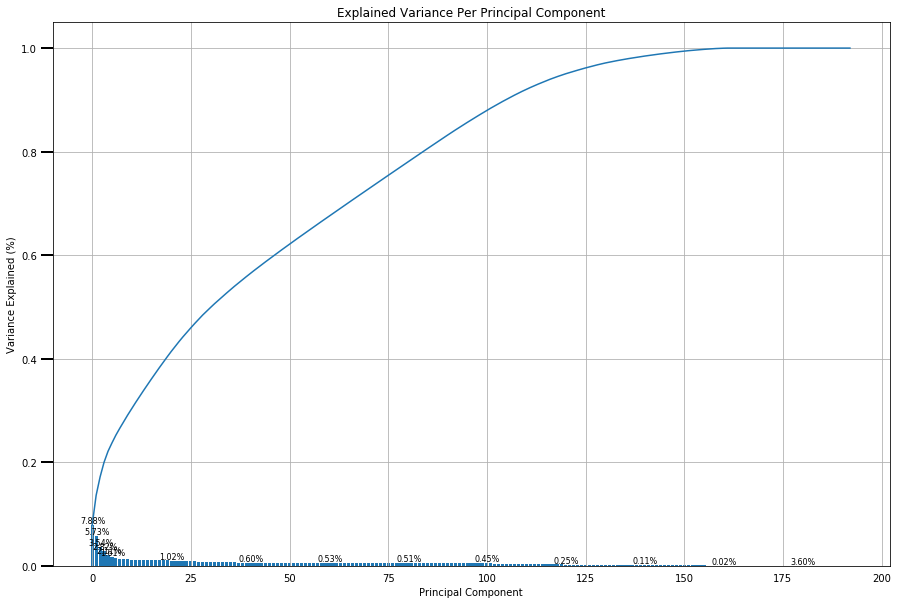

In [59]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca_fit)


In [60]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=125, random_state=42)
pca.fit(azdias_scaled)
pca_data = pca.transform(azdias_scaled)
pca_data.shape

(795469, 125)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

After standardising the data, I have used scree_plot helper function to plot the principal components. As per the plot above, first 30 Principal Components explains about 50% of all the variance. I am keeping first 125 principal components out of 200 for the analysis, as the explain about 95% of total variance.

It is interesting to note that the last 50 components (#150-200) explain very little of the variance.


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
def investigate_PC(pca, component, feature_names):
    #code inspired by helper_functions.py in PCA lesson
    '''
    Prints association of a feature to the weights of its components
    INPUT: pca: PCA object, compnent: which component is to be investigated (0 indexed),
            feature_names: the corresponding feature names to PCA
    OUTPUT: None
    '''
    
    num_out = 10
    
    if(component <= len(pca.components_)):
        pca_feature_map = pd.DataFrame({'weight': pca.components_[component],
                                        'name': feature_names})
        
        pca_feature_map = pca_feature_map.sort_values(by='weight', ascending=False)
        
        print('Principal Component {}\n---------------\n'.format(component+1))
        print('TOP {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[:num_out,:]))
        print('\n BOTTOM {0} PRINCIPAL COMPONENTS \n {1}'.format(num_out, pca_feature_map.iloc[-num_out:,:]))
            
    else:
        print('Error in selecting component')

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

investigate_PC(pca, 0, azdias_scaled.columns)

Principal Component 1
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight                    name
110  0.196139      LP_STATUS_GROB_1.0
190  0.184414  CAMEO_INTL_2015_WEALTH
29   0.184312      HH_EINKOMMEN_SCORE
52   0.182638              PLZ8_ANTG3
53   0.175992              PLZ8_ANTG4
57   0.158888             ORTSGR_KLS9
42   0.156713                EWDICHTE
7    0.148075        FINANZ_HAUSBAUER
39   0.129211             KBA05_ANTG4
100  0.126981      LP_STATUS_FEIN_1.0

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                name
113 -0.112976  LP_STATUS_GROB_4.0
192 -0.115916               RURAL
43  -0.129583          INNENSTADT
55  -0.132654            PLZ8_GBZ
34  -0.137664         KONSUMNAEHE
36  -0.180246         KBA05_ANTG1
40  -0.181128           KBA05_GBZ
50  -0.182923          PLZ8_ANTG1
46  -0.188301          MOBI_REGIO
2   -0.191134   FINANZ_MINIMALIST


In [63]:

# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_PC(pca, 1, azdias_scaled.columns)

Principal Component 2
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight                  name
0    0.232946  ALTERSKATEGORIE_GROB
4    0.219003      FINANZ_VORSORGER
124  0.199923            ZABEOTYP_3
17   0.180314             SEMIO_ERL
16   0.163474            SEMIO_LUST
10   0.155480        RETOURTYP_BK_S
30   0.122949        W_KEIT_KIND_HH
61   0.108257     CJT_GESAMTTYP_2.0
70   0.098925           FINANZTYP_5
100  0.096961    LP_STATUS_FEIN_1.0

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                   name
47  -0.161801      ONLINE_AFFINITAET
18  -0.165216             SEMIO_KULT
19  -0.168273              SEMIO_RAT
5   -0.204767         FINANZ_ANLEGER
23  -0.205506          SEMIO_PFLICHT
24  -0.208037            SEMIO_TRADV
13  -0.214656              SEMIO_REL
6   -0.214913  FINANZ_UNAUFFAELLIGER
3   -0.227076          FINANZ_SPARER
189 -0.230713           YOUTH_DECADE


In [64]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

investigate_PC(pca, 2, azdias_scaled.columns)

Principal Component 3
---------------

TOP 10 PRINCIPAL COMPONENTS 
        weight               name
15   0.316904         SEMIO_VERT
12   0.258404          SEMIO_FAM
11   0.255522          SEMIO_SOZ
18   0.249496         SEMIO_KULT
70   0.137549        FINANZTYP_5
2    0.130366  FINANZ_MINIMALIST
118  0.122815    SHOPPER_TYP_0.0
122  0.119307         ZABEOTYP_1
13   0.113082          SEMIO_REL
14   0.088095          SEMIO_MAT

 BOTTOM 10 PRINCIPAL COMPONENTS 
        weight                name
101 -0.079195  LP_STATUS_FEIN_2.0
120 -0.092198     SHOPPER_TYP_2.0
66  -0.099695         FINANZTYP_1
19  -0.152671           SEMIO_RAT
5   -0.155304      FINANZ_ANLEGER
17  -0.207104           SEMIO_ERL
20  -0.265871          SEMIO_KRIT
21  -0.279049           SEMIO_DOM
22  -0.311362          SEMIO_KAEM
1   -0.342170           ANREDE_KZ


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

#### Interpreting 1st Principal Component

The first principal component is explained the most by feature LP_STATUS_GROB_1.0 which informs about the social status of individuals on rough scale. Another top features, namely, HH_EINKOMMEN_SCORE, CAMEO_INTL_2015_WEALTH, PLZ8_ANTG3 informs about net income, wealth and financial staus. We can reconcile it with the fact that positive features in same direction are correlated and increase in one tends to increase in other. Here, increase in net income or wealth will led to increase in overall financial and social status. The three most negative features are: PLZ8_ANTG1, MOBI_REGIO, FINANZ_MINIMALIST. These features seems to explain individual with low financial interest and it shoes negative correlation with top features.

#### Interpreting 2nd Principal Component

Top three features of 2nd Principal Component are ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, ZABEOTYP_3 which explains population's age, financial interests and environmental awareness.

Bottom three features of 2nd Principal Component are SEMIO_REL, FINANZ_SPARER, YOUTH_DECADE. These features are mixture of perosnality type, age and financial interests of individuals.

Although both bottom and top features seem to cover common aspects such as age and financial interest but differ in terms of personality types of individuals.

#### Interpreting 3rd Principal Component

Top features of 3rd principal components are ANREDE_KZ_1, SEMIO_VERT, SEMIO_FAM, SEMIO_SOZ etc.

Bottom features of 3rd principal components are ANREDE_KZ_2, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT etc.

3rd principal component differes bottom and top features by individual gender and personality traits. Top fetures explains individual with traits such as dreamful, family-minded and socially-minded where as bottom fetures explains individual with traits such as combative attitude, dominant-minded and critical-minded.

As we move through principal components, the weights across features tend to increase, which explains increase in variability captured by later principal components.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [65]:
from sklearn.cluster import KMeans

kmeans_score = []
# Over a number of different cluster counts...
for i in range(2,20,2):
    # run k-means clustering on the data and...
    kmeans = KMeans(i).fit(pca_data)
    
    # compute the average within-cluster distances.
    kmeans_score.append(abs(kmeans.score(pca_data)))
    

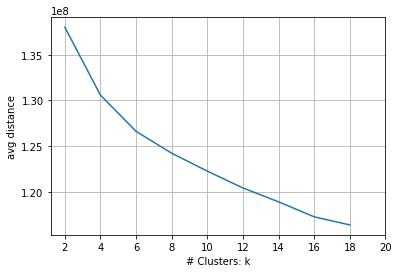

In [66]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
fig, ax = plt.subplots()
ax.plot(range(2,20,2), kmeans_score)
ax.set(ylabel='avg distance', xlabel='# Clusters: k')
ax.grid()
plt.xticks(np.arange(2,21,2))
plt.show()


In [67]:
pca_data.shape

(795469, 125)

In [108]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans

kmeans = KMeans(12, random_state=42).fit(pca_data)
kmeans_pred = kmeans.predict(pca_data)

### Discussion 3.1: Apply Clustering to General Population


After plotting clusters numbers against average distance within cluster, it seems that there is sharp fall in distance of first four clusters and after that there is gradual decrease in average distance. Although a sharp elbow curve is missing in graph but I chose to segment the population into 12 clusters, since it seems to be reasonable choice after sudden fall in first 6 clusters.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [109]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0
5,1,3,1,4.0,5,1,5,1,2,3,...,2.0,3.0,2.0,1.0,1.0,5.0,5.0,3.0,7.0,5.0
6,2,4,1,2.0,5,1,5,1,1,2,...,3.0,2.0,1.0,0.0,1.0,5.0,5.0,2.0,3.0,2.0
7,1,4,1,2.0,5,1,5,1,2,2,...,3.0,3.0,1.0,1.0,1.0,3.0,3.0,3.0,4.0,3.0
8,2,4,2,1.0,2,2,5,1,1,5,...,1.0,4.0,2.0,1.0,5.0,5.0,4.0,3.0,8.0,3.0
9,1,3,1,3.0,5,2,4,1,3,1,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,3.0,6.0,4.0


In [110]:
azdias_cleaned

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,nulls
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2,5.0,1,5,2,5,4,5,1,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1,5.0,4,3,4,1,3,2,5,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0,0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0,0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0,0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0,0


In [111]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned = clean_data(customers)
customers_cleaned

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,AVANTGARDE_MAINSTREAM,YOUTH_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE,RURAL
0,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,1.0,50.0,1.0,3.0,1
2,4.0,2,5,1,5,1,4,4,1,2.0,...,0,0,0,0,0,1.0,50.0,3.0,4.0,0
3,4.0,1,5,1,5,2,1,2,0,2.0,...,0,0,0,0,0,0.0,40.0,2.0,4.0,1
4,3.0,1,3,1,4,4,5,2,0,3.0,...,0,0,0,0,0,0.0,70.0,4.0,1.0,0
5,3.0,1,5,1,5,1,2,3,1,3.0,...,0,0,0,0,0,1.0,50.0,3.0,4.0,0
6,4.0,1,5,1,5,1,1,2,1,2.0,...,0,0,0,0,0,1.0,50.0,2.0,3.0,1
7,4.0,1,5,1,5,1,2,2,1,1.0,...,0,0,0,0,0,1.0,50.0,1.0,5.0,0
8,4.0,2,2,2,5,1,1,5,0,2.0,...,0,0,0,0,1,0.0,40.0,5.0,5.0,0
9,3.0,1,5,2,4,1,3,1,1,3.0,...,0,0,0,0,0,1.0,70.0,1.0,5.0,0
11,4.0,1,5,1,5,1,3,2,1,1.0,...,0,0,0,0,0,1.0,50.0,1.0,4.0,0


In [112]:
# one of the feature is missing in customer data set
for column in azdias_scaled.columns:
    if column not in customers_cleaned.columns:
        print(column)

# adding missing feature
customers_cleaned['GEBAEUDETYP_5.0'] = 0

GEBAEUDETYP_5.0


In [113]:
# checking for additional columns in customers data
for column in customers_cleaned.columns:
    if column not in azdias_low_18.columns:
        print(column)
customers_cleaned.shape

(141322, 193)

In [114]:
customers_cleaned.isna().sum().describe()

count     193.000000
mean      490.466321
std      1580.810206
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      9833.000000
dtype: float64

In [115]:
customers_imputed = imputer.transform(customers_cleaned)
pd.DataFrame(customers_imputed).isna().sum().describe()

count    193.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [116]:
customers_scaled = scaler.transform(customers_imputed)
customers_scaled

array([[ 1.18383186, -1.04370507,  1.40971866, ..., -0.18631704,
        -1.25159307, -0.55299447],
       [ 1.18383186,  0.95812507,  1.40971866, ...,  0.4956606 ,
        -1.92384889, -0.55299447],
       [ 1.18383186, -1.04370507,  1.40971866, ...,  0.4956606 ,
        -1.25159307, -0.55299447],
       ..., 
       [ 1.18383186, -1.04370507,  1.40971866, ...,  0.4956606 ,
        -1.92384889, -0.55299447],
       [ 0.20037469,  0.95812507, -0.7679724 , ...,  0.4956606 ,
        -1.92384889, -0.55299447],
       [-0.78308248, -1.04370507,  1.40971866, ..., -0.18631704,
        -1.25159307, -0.55299447]])

In [117]:
customers_pca = pca.transform(customers_scaled)
customers_pca

array([[-17.6061677 ,   3.37582753,  14.38062432, ...,  26.43129802,
          4.5635754 ,  18.57805214],
       [-14.18597789,   5.87127613,   9.30550386, ...,  28.24735144,
          4.99967995,  16.48616298],
       [-14.97332676,   1.06311565,  10.89496735, ...,  22.88356691,
          3.13712337,  14.54747361],
       ..., 
       [-17.26893753,   4.02442855,  12.91784554, ...,  27.08573733,
          5.24230248,  17.23282693],
       [-18.62072034,   2.83118691,  12.27166583, ...,  38.96572371,
          6.38398364,  23.95723258],
       [-17.5373648 ,  -2.11725412,  12.87386002, ...,  27.66244234,
          4.67451459,  18.16091879]])

In [118]:
pca_data.shape

(795469, 125)

In [119]:
customers_pca.shape

(141322, 125)

In [120]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [121]:
customers_clusters_pred = kmeans.predict(customers_pca)
customers_clusters_pred

array([2, 1, 2, ..., 2, 1, 2], dtype=int32)

In [122]:
np.bincount(kmeans_pred)

array([ 89981,  51221,  56707,  26330, 100389, 101348,  29954,  34725,
       105117,  60386,  68429,  70882])

In [123]:
np.bincount(customers_clusters_pred)

array([    0, 50202, 91119,     0,     0,     0,     0,     1])

In [124]:
azdias_low_18.shape

(795469, 193)

In [125]:
customers_cleaned.shape

(141322, 193)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

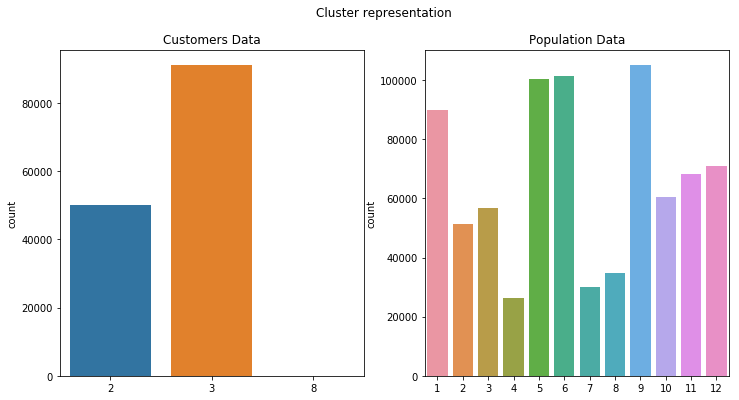

In [127]:
#  Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
gen_pop = azdias_scaled.shape[0]

customer_pop = customers_cleaned.shape[0]

gen_pop_cluster_count = np.bincount(kmeans_pred)
customer_cluster_count = np.bincount(customers_clusters_pred)
customer_cluster_count = list(customer_cluster_count)
customer_cluster_count.extend([0,0,0, 0])

gen_pop_cluster_prop = [round(x/gen_pop, 2) for x in gen_pop_cluster_count]
customer_cluster_prop = [round(x/customer_pop, 2) for x in customer_cluster_count]

prop_data = pd.DataFrame({'gen_pop': gen_pop_cluster_prop, 'customers': customer_cluster_prop}, index=np.arange(1,13))
prop_data.index.names=['Cluster']


'''CLUSTER COUNT'''

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=False)
fig.suptitle('Cluster representation')
# customer data representation
ax1.set_title('Customers Data')
sns.countplot(customers_clusters_pred+1, ax=ax1)
# popluation data representation
ax2.set_title('Population Data')
sns.countplot(kmeans_pred+1, ax=ax2)
plt.show()

In [128]:
# general population and customer data proportion with LOW NAN 
prop_data

,gen_pop,customers
Cluster,,
1,0.11,0.00
2,0.06,0.36
3,0.07,0.64
4,0.03,0.00
5,0.13,0.00
6,0.13,0.00
7,0.04,0.00
8,0.04,0.00
9,0.13,0.00


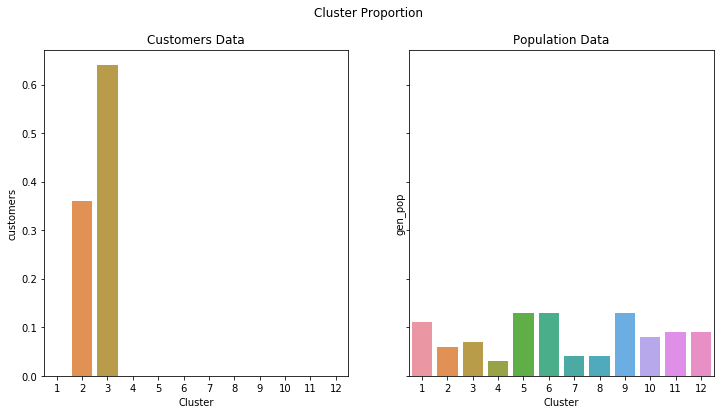

In [129]:
'''CLUSTER PROPORTION'''

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6), sharey=True)
fig.suptitle('Cluster Proportion')
# customer data representation
ax1.set_title('Customers Data')
sns.barplot(x=prop_data.index, y=prop_data['customers'], ax=ax1)
# popluation data representation
ax2.set_title('Population Data')
sns.barplot(x=prop_data.index, y=prop_data['gen_pop'], ax=ax2)
plt.show()

##### Cluster Representation for  Population & Customer Data 

In [130]:
def cluster_centers(cluster):
    features = pd.Series((pca.inverse_transform(kmeans.cluster_centers_[cluster-1])), index=customers_cleaned.columns)
    print("Top 3 features in cluster")
    print(features.sort_values(ascending=False)[:3])
    print("Bottom 3 features in cluster")
    print(features.sort_values(ascending=False)[len(features)-3:])

In [134]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

for data in prop_data.iterrows():
    val = (data[1]['customers'] - data[1]['gen_pop'])*100
    if val > 0:
        print("Customer Cluster "+str(data[0])+" is Over Represented by: "+str(round(val, 2))+" % ")
        cluster_centers(data[0])
        print("----------------------------------------------------------------------")

Customer Cluster 2 is Over Represented by: 30.0 % 
Top 3 features in cluster
LP_STATUS_GROB_5.0     2.235342
LP_STATUS_FEIN_10.0    2.235342
YOUTH_DECADE           1.805985
dtype: float64
Bottom 3 features in cluster
SEMIO_KULT           -0.976235
SEMIO_FAM            -1.008604
HH_EINKOMMEN_SCORE   -1.286674
dtype: float64
----------------------------------------------------------------------
Customer Cluster 3 is Over Represented by: 57.0 % 
Top 3 features in cluster
LP_STATUS_GROB_5.0     2.262358
LP_STATUS_FEIN_10.0    2.262358
GREEN_AVANTGARDE       1.782934
dtype: float64
Bottom 3 features in cluster
FINANZ_HAUSBAUER     -0.954615
ANREDE_KZ            -0.987696
HH_EINKOMMEN_SCORE   -1.320681
dtype: float64
----------------------------------------------------------------------


In [132]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

for data in prop_data.iterrows():
    val = (data[1]['customers'] - data[1]['gen_pop'])*100
    if val < 0:
        print("Customer Cluster "+str(data[0])+" is Under Represented by: "+str(round(val))+"%")
        cluster_centers(data[0])
        print("----------------------------------------------------------------------")

Customer Cluster 1 is Under Represented by: -11.0%
Top 3 features in cluster
LP_STATUS_FEIN_1.0    1.128875
SEMIO_ERL             1.046824
SEMIO_KAEM            1.022792
dtype: float64
Bottom 3 features in cluster
SEMIO_FAM    -1.002290
SEMIO_REL    -1.003881
SEMIO_KULT   -1.163649
dtype: float64
----------------------------------------------------------------------
Customer Cluster 4 is Under Represented by: -3.0%
Top 3 features in cluster
LP_STATUS_FEIN_5.0    5.233738
LP_STATUS_GROB_2.0    1.917065
FINANZ_ANLEGER        1.483847
dtype: float64
Bottom 3 features in cluster
LP_STATUS_GROB_1.0     -0.828917
HH_EINKOMMEN_SCORE     -1.067987
ALTERSKATEGORIE_GROB   -1.087565
dtype: float64
----------------------------------------------------------------------
Customer Cluster 5 is Under Represented by: -13.0%
Top 3 features in cluster
LP_STATUS_FEIN_2.0    1.579530
FINANZTYP_1           1.291098
SEMIO_RAT             1.234811
dtype: float64
Bottom 3 features in cluster
ALTERSKATEGORIE_GRO

### Discussion 3.3: Compare Customer Data to Demographics Data

There are 2 clusters only which are highly over represented in customer data compared to demographic data. Out of these 2 clusters, cluster 3 is the most over represented one by difference of 57%.

#### Over Represented Clusters 

##### Cluster 3
Top features of this clusters are: LP_STATUS_GROB_5.0, LP_STATUS_FEIN_10.0 and GREEN_AVANTGARDE. These features describes people with high social status and top income earner. Individuals in this cluster seems to be more environment fiendly.

Least represented feature is HH_EINKOMMEN_SCORE which is again in correlation with top features as HH_EINKOMMEN_SCORE represents estimated household net income.
 
People with high social status and net income are significantly over represented in customer data and this is a great target audience for any marketing campaign.

##### Cluster 2
Customer Cluster 2 is Over Represented by: 30 %. 

Top 3 features in cluster are LP_STATUS_GROB_5.0, LP_STATUS_FEIN_10.0 and YOUTH_DECADE. This cluster is almost similar to cluster 3 top features. This clearly signifies again that people with hih socialstatus and net income are the tageted audience.


#### Under Represented Clusters

##### Cluster 5 and 6
These are the most under represented clusters. It is under represented by 13%.

Top 3 features of cluster 5 are LP_STATUS_FEIN_2.0, FINANZTYP_1 and SEMIO_RAT. These features describes people with low income and low financila interest. Components of this clusters makes negative correlation with Cluster 3 & 2 which is dominated with people having high soacial and financial status. This makes complete sense that we should not consider people with low income or low financila interest as targeted marketing audience.

Top 3 features of cluster 5 are LP_STATUS_FEIN_1.0, FINANZTYP_5 and SEMIO_VERT. These are the people with low income but more of investor personality. Since they doesn't have much earnings so they might avoid spending their earnings. 


##### Other under represented Clusters 
Top features of other under represented Clusters are mojorly describing people with low financial interests and low net income.


##### Overall Analysis
Overall this shows that people with high social status and high net worth will be the significant target audience for the mail order company. Also, people who are more influence with environment sustainability could come under good target audience.
People with low financial interesets or low net income should be avaoided from the marketing campaign.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.